# Идентификация токсичных комментариев

Проект посвящен созданию модели, определяющей токсичные комментарии к правкам википедии.

Задача: построить модель со значением метрики качества *F1* не меньше 0.75. 

## Подготовка

Импорты всего нужного.

In [1]:
is_final = True

import warnings
warnings.filterwarnings('ignore')
import os.path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.corpus import words as ntlk_words
from sklearn import model_selection, tree, linear_model, metrics, ensemble, preprocessing, neighbors, compose, naive_bayes, svm, set_config, impute, manifold, feature_selection, inspection, pipeline, decomposition, feature_extraction
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
from transformers import BertTokenizer, BertModel
import phik
import enchant
import optuna
import string
#optuna.logging.set_verbosity(optuna.logging.INFO)
optuna.logging.set_verbosity(optuna.logging.WARNING)
import time
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler, Sampler, SequentialSampler
import regex as re
import requests
from io import BytesIO
import spacy
import gc
from IPython.display import clear_output
import catboost as cat
from catboost import Pool, cv
from unidecode import unidecode
import gensim.downloader

Важная функция для многократных запусков пайторча.

In [2]:
def clear_GPU():
    gc.collect()
    torch.cuda.empty_cache()

Проверяем, что GPU в наличии.

In [3]:
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.')
    DEVICE = torch.device("cpu")
else:
    print('CUDA is available!')
    DEVICE = torch.device("cuda:0")

CUDA is available!


Настраиваем визуализации и рандом.

In [4]:
%matplotlib inline
set_config(display="diagram")
sns.set()
sns.set(rc = {'figure.figsize':(12,8)})
sns.set_style("whitegrid")
sns.set_palette('pastel')
plt.rcParams["figure.figsize"] = (12, 8)

random_state = 2077
np.random.seed(seed=random_state)
torch.manual_seed(random_state);

Сразу подготовим NLTK.

In [5]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sergey\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Sergey\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Sergey\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Sergey\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### Загрузка данных

In [6]:
df = pd.read_csv('toxic_comments.csv').sample(
    frac=1, random_state=0).reset_index(drop=True)
print(df.info())
df['toxic'].mean()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB
None


0.10167887648758234

У нас 160к строк, из них к классу 1 относится 10%. Пропусков нет, типы данных адекватные.

Для борьбы с дисбалансом будем использовать два подхода (по возможности одновременно):
- сбалансируем веса выборок, но не просто обратно пропорционально (1 к 9), а обратно пропорционально корню из дисбаланса (то есть 1 к 3)
- будем выбирать порог принятия решения для максимизации метрики F1 на валидационной или обучающей выборке. Затем применим найденный порог на тестовой выборке

## EDA

Посмотрим на позитивные примеры.

In [7]:
for i, t in enumerate(df[df['toxic'] == 1]['text'].sample(n=3, random_state=random_state)):
    if i > 0: print('-----------------------------------------')
    print(t)

"

u are 1 ****ing cheeky **** mate i swear i am goin 2 wreck u i swear on my mums life... but seriously I'll still block you if you keep this up. Talk "
-----------------------------------------
Please make DreamGuy and his tools stop messing with my user page. I have cleaned it off in good faith and that asshole keeps putting it back
-----------------------------------------
What the HECK is a Woman Artist??? 

Is this creature somehow different from a MALE artist?  Is this creature less than a MALE artist?  What is this creature, exactly?


Какие-то они не очень позитивные...

Теперь нулевой класс:

In [8]:
for i, t in enumerate(df[df['toxic'] == 0]['text'].sample(n=3, random_state=random_state)):
    if i > 0: print('-----------------------------------------')
    print(t)

"
I would actually agree that the product is not worthy of having a Wikipedia article. But it is a kind of flag bearer for this type of butter blend product and as such get a fair amount of media coverage which generates some general interest. Irrespective of this, if the article stands then I hope you will agree it should be informative. The most important element of that is to say what it is. 
As far as I know the product comes under the category of margarine/butter blend. I've put a reference to where a retailer describes it as this. A margarine is a ""water-in-oil emulsion derived from vegetable/animal fats ... suitable as spread"" and that's exactly what this product is. And a margarine is defined as an imitation butter spread. What the reader needs to know about this product in a nutshell is that it is a margarine product which is marketed as if it had butter in it (that it has 'butter taste'  implying a butter blend) but that it is not actually blended with natural butter. The p

### Частоты слов

Визуализируем основные слова из наборов. Идея взята [отсюда](https://www.kaggle.com/code/jagangupta/stop-the-s-toxic-comments-eda).

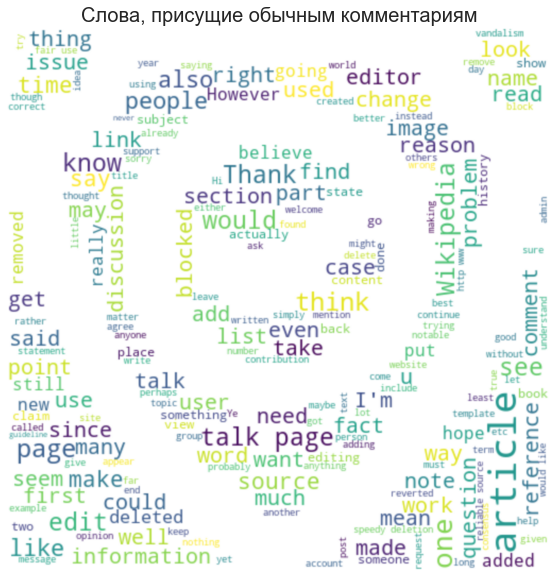

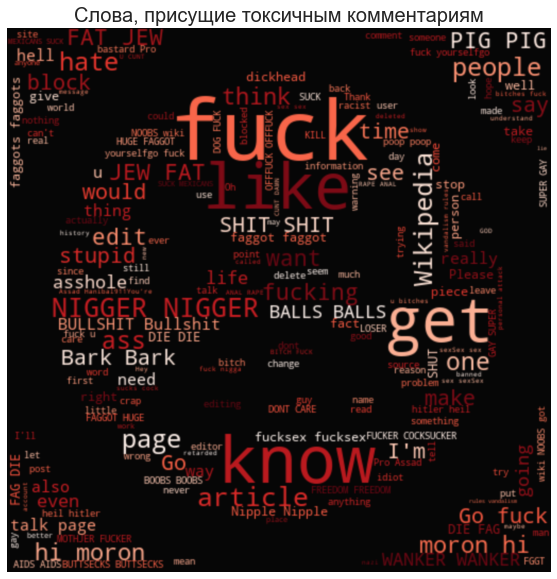

In [9]:
if is_final:
    img = Image.open(BytesIO(requests.get('https://cdn-icons-png.flaticon.com/512/99/99665.png').content))
    wc = WordCloud(background_color="white", max_words=200 ,mask=np.array(img), stopwords=stop_words)
    wc.generate(" ".join(df[df.toxic==0].text.values))
    plt.figure(figsize=(10,10))
    plt.axis("off")
    plt.title("Слова, присущие обычным комментариям", fontsize=20)
    plt.imshow(wc.recolor(colormap='viridis', random_state=17), alpha=0.98, interpolation="bicubic")
    plt.show()
    img = Image.open(BytesIO(requests.get('https://cdn-icons-png.flaticon.com/512/42/42887.png').content))
    wc = WordCloud(background_color="black", max_words=200 ,mask=np.array(img), stopwords=stop_words)
    wc.generate(" ".join(df[df.toxic==1].text.values))
    plt.figure(figsize=(10,10))
    plt.axis("off")
    plt.title("Слова, присущие токсичным комментариям", fontsize=20)
    plt.imshow(wc.recolor(colormap='Reds', random_state=17), alpha=0.98, interpolation="bicubic");

Даже тут уже видно, что наиболее популярные слова сильно отличаются.

То же самое, но менее художественно.

In [10]:
count_vec_fitted = feature_extraction.text.CountVectorizer(stop_words=stop_words, strip_accents='unicode', lowercase=True)
count_vec_fitted.fit(df['text'])

def word_count_barplot(toxic=None, plot=True):
    if toxic == None: tmp = df.copy()
    else: tmp = df[df['toxic'] == toxic].copy()
    count = count_vec_fitted.transform(tmp['text'])
    freq_list = np.asarray(count.sum(axis=0)).reshape(-1)
    word_list = count_vec_fitted.get_feature_names()
    count_matrix = list(zip(word_list, freq_list))
    tmp2 = pd.DataFrame(count_matrix).sort_values(1, ascending=False).rename(columns={0:'word', 1:'count'}).reset_index(drop=True)
    tmp2['freq'] = tmp2['count'] / len(tmp2)
    if plot: sns.barplot(data=tmp2.head(30), x='freq', y='word')
    return tmp2

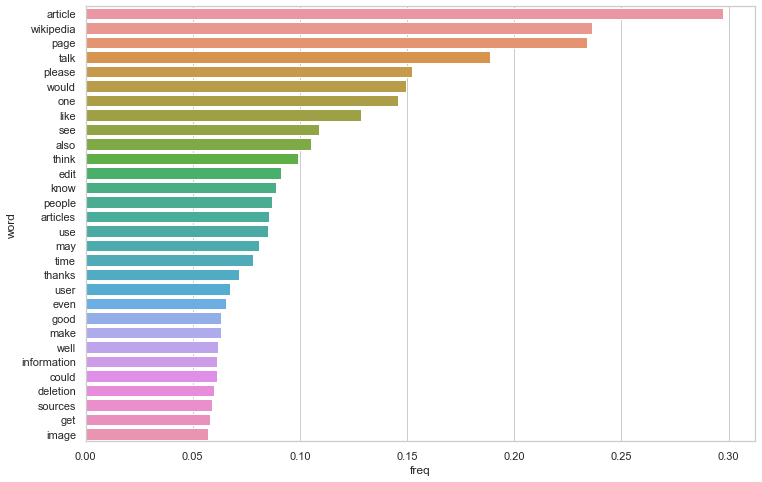

In [11]:
if is_final: word_count_barplot(0);

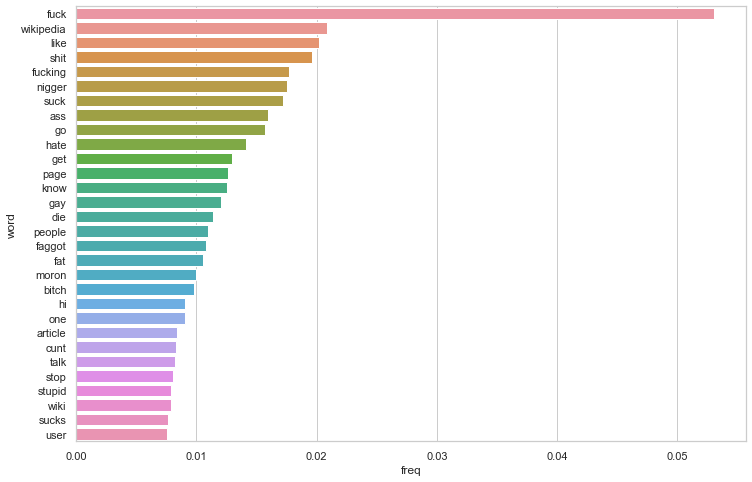

In [12]:
if is_final: word_count_barplot(1);

Теперь посмотрим, какую долю датасета занимают "популярные" слова.

Сразу проверим, какие слова входят в английские словари.

In [13]:
if is_final:
    words = word_count_barplot(None, plot=False)
    eng_dict = enchant.Dict("en_US")
    nltk.download('words')
    word_list = ntlk_words.words()
    word_list = [i.lower() for i in word_list]
    words['in_vocab'] = (words['word'].apply(lambda x: eng_dict.check(x))) | (words['word'].isin(word_list))
    print('всего слов', len(words))
    total_words = words['count'].sum()
    for i in np.arange(0, 5):
        n = 10**i
        tmp = words[words['count'] > n]
        l = len(tmp)
        total_words_n =  tmp['count'].sum() / total_words
        print(f'слова, встречающиеся чаще {n} раз: количество, шт. {l} ({l/len(words):.1%}), формируют {total_words_n:.1%} мешка слов')

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Sergey\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


всего слов 188517
слова, встречающиеся чаще 1 раз: количество, шт. 89269 (47.4%), формируют 98.2% мешка слов
слова, встречающиеся чаще 10 раз: количество, шт. 25182 (13.4%), формируют 94.0% мешка слов
слова, встречающиеся чаще 100 раз: количество, шт. 6117 (3.2%), формируют 83.5% мешка слов
слова, встречающиеся чаще 1000 раз: количество, шт. 959 (0.5%), формируют 56.0% мешка слов
слова, встречающиеся чаще 10000 раз: количество, шт. 45 (0.0%), формируют 14.2% мешка слов


Видно, что даже топовые слова уже неплохо передают "окраску" комментариев.

Кроме того, видно, что есть колоссальное количество (50%) редких слов, которые встречаются всего по 1 разу - они, вероятно, бесполезны, модель будет просто переобучаться на них.

### Не-словарные слова

Посмотрим, какие слова не входят в английский словарь.

In [14]:
if is_final:
    words[(words['in_vocab']==False) & (words['count']>1)].head(15)

Многие популярные слова вполне "нормальны". Некоторые из них являются некорректными написаниями обычных слов, например, im = i'm. С другой стороны, их тысячи, поэтому, вероятно, стоит не трогать - в таком написании могут быть запечатлены эмоции автора.

Посмотрим на несловарные слова, которых более 1 и менее 100.

In [15]:
if is_final:
    tmp = words[(words['in_vocab']==False) & (words['count']>1) & (words['count']<100)]
    print(len(tmp))
    tmp.tail(15)
    del(tmp)
    del(words)

45113


### Количественные оценки записей

In [16]:
tmp = df.copy()
tmp['count_sentences'] = tmp['text'].apply(lambda x: len(re.findall("\n",str(x)))+1)
tmp['count_word'] = tmp['text'].apply(lambda x: len(str(x).split()))
tmp['count_unique_word']= tmp["text"].apply(lambda x: len(set(str(x).split())))
tmp['count_letters']= tmp["text"].apply(lambda x: len(str(x)))
tmp["count_punctuations"] =tmp["text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
tmp["count_words_upper"] = tmp["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
tmp["mean_word_len"] = tmp["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

tmp['word_unique_percent'] = tmp['count_unique_word'] * 100 / tmp['count_word']
tmp['punct_percent'] = tmp['count_punctuations'] * 100 / tmp['count_word']

In [17]:
def plot_two_box(col_name, ax=None):
    tmp2 = tmp.copy()
    q = 0.05
    max_val = tmp2[col_name].quantile(1-q)
    min_val = tmp2[col_name].quantile(q)
    iqr = max_val - min_val
    tmp2 = tmp2[tmp2[col_name] >= min_val - iqr / 100]
    tmp2 = tmp2[tmp2[col_name] <= max_val + iqr / 100]
    sns.histplot(data=tmp2, hue='toxic', x=col_name, stat='density', common_norm=False, bins=30)

Сначала анализ гистограмм.

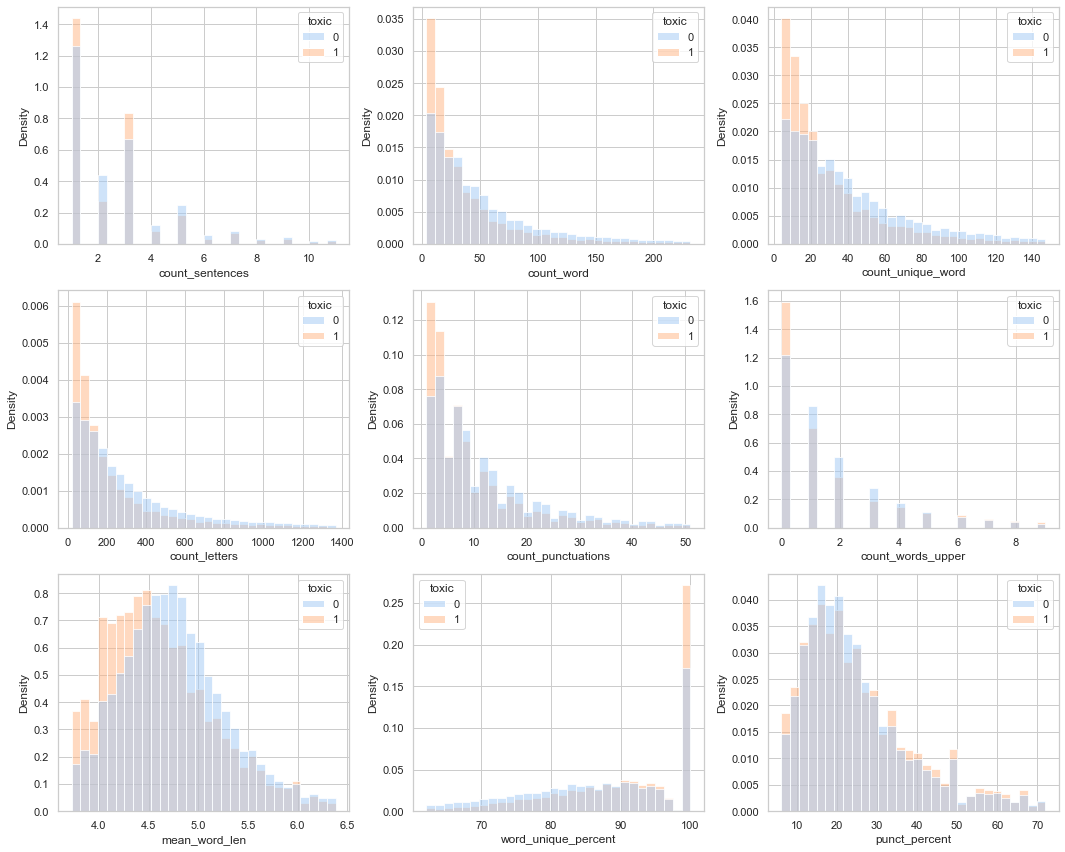

In [18]:
if is_final:
    fig = plt.figure(figsize=(15,12))
    for i, col_name in enumerate(list(tmp.columns[2:])):
        ax = plt.subplot(3,3,i+1)
        plot_two_box(col_name, ax)
    fig.tight_layout()

В целом видно, что в токсичных комментариях чуть меньше:
- слов
- уникальных слов
- букв
- пунктуации
- средняя длина слов

В то же время в токсичных комментариях больше процент уникальных слов (что, вероятно, определяется более короткими текстами).

Но сразу можно отметить, что эти закономерности выражены крайне слабо.

Посмотрим на хитмэп.

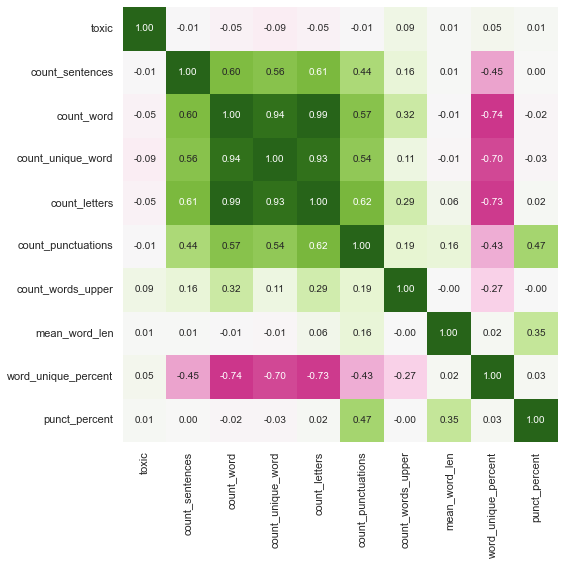

In [19]:
if is_final:
    tmp2 = tmp[tmp.columns[1:]]
    sns.heatmap(data=tmp2.corr(),
        square=True, cmap="PiYG",
        center=0,
        cbar=False,
        annot=True, fmt='.2f', annot_kws={'size': 10});

Видим, что для линейной модели все эти признаки бесполезны.

Посмотрим еще на нелинейную корреляцию.

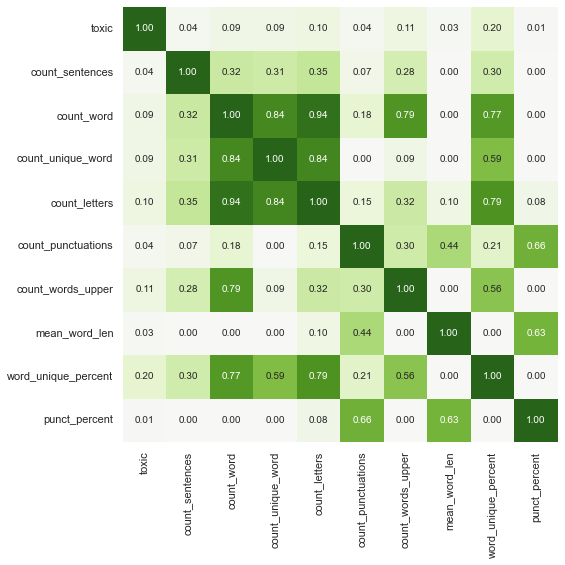

In [20]:
if is_final:
    tmp2 = tmp[tmp.columns[1:]]
    sns.heatmap(data=tmp2.phik_matrix(interval_cols=tmp2.columns),
        square=True, cmap="PiYG",
        center=0,
        cbar=False,
        annot=True, fmt='.2f', annot_kws={'size': 10});

Видим, что и тут все корреляции очень слабые. Вряд ли эти признаки стоит использовать для решения задачи.

## Предобработка

Напишем функцию "легкой" обработки текста. Легкой - значит, мы убираем только то, что БЕРТ не сможет прочитать, или мы уверены, что оно ему не поможет.

Конкретные преобразования подобраны вручную после просмотра и индивидуальной обработки порядка 100 записей. Для повышения качества предсказаний можно добавлять новые "безопасные" преобразования, но придумывать их приходится самостоятельно.

In [22]:
def clean_light(data, col_in, col):
    data[col] = data[col_in].str.lower()

    # non-english characters to english
    data[col] = data[col].apply(unidecode)

    # URL lnks
    data[col] = data[col].str.replace(r'https?:\/\/\S+|www\.\S+', ' url ', regex=True)
    data[col] = data[col].str.replace(r'\S+\.html', ' url ', regex=True)
    # ip address
    data[col] = data[col].str.replace(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', ' ip address ', regex=True)

    data[col] = data[col].str.replace(r'ø', 'o', regex=True)
    data[col] = data[col].str.replace(r'f[^a-zA-Z]ck', 'fuck', regex=True)

    # domen-specific combinations
    data[col] = data[col].str.replace(r'user:\S+', '', regex=True)
    data[col] = data[col].str.replace(r'user talk:\S+', '', regex=True)
    data[col] = data[col].str.replace(r'image:\S+', '', regex=True)
    data[col] = data[col].str.replace(r'\(talk\)', '', regex=True)
    data[col] = data[col].str.replace(r'{talk contribs}', '', regex=True)
    data[col] = data[col].str.replace(r'\(utc\)', '', regex=True)
    data[col] = data[col].str.replace(r'\(more\.\.\.\)', '', regex=True)

    # punctuation
    data[col] = data[col].str.replace(r'\.\.', '...', regex=True)
    data[col] = data[col].str.replace(r'\.{4,}', '...', regex=True)
    data[col] = data[col].str.replace(r':+', ':', regex=True)
    data[col] = data[col].str.replace(r'\"+', '\"', regex=True)
    data[col] = data[col].str.replace(r'\'+', '\'', regex=True)

    # final cleaning
    data[col] = data[col].str.replace(r"[♣|§|♠|*|/|=|#|•|~|^|>|<|►|_|\]|\[|-|@]", ' ', regex=True)
    data[col] = data[col].str.replace(r'\n+', '\n', regex=True)
    data[col] = data[col].str.replace(r'[^\S\r\n]+', ' ', regex=True)
    # data[col] = data[col].str.replace(, regex=True)

    data[col] = data[col].str.strip()
    data[col] = data[col].str.strip('\'')
    data[col] = data[col].str.strip('\"')
    data[col] = data[col].str.strip(':')

    return data

Так как обработка минималистична, перезапишем исходный столбец.

In [23]:
%%time
df = clean_light(df, 'text', 'text')

Wall time: 12.8 s


## Создание выборок

Разделим выборку на обучение и тест, создав отдельную колонку с этим признаком. Кроме того, индексы выборок запишем в отдельные переменные.

In [24]:
train_idx, test_idx = model_selection.train_test_split(
    df.index, test_size=0.2, shuffle=True, stratify=df['toxic'], random_state=random_state)
df['tst'] = 0
df.loc[test_idx, 'tst'] = 1

Сразу разделим обучающую выборку на "маленькую" обучающую и валидационную.

In [25]:
small_train_idx, small_val_idx = model_selection.train_test_split(
    train_idx, test_size=0.2, shuffle=True, stratify=df['toxic'].loc[train_idx], random_state=random_state)

Пара функций для обучения.

У нас несбалансированный датасет, поэтому метрика будет зависеть от порога принятия решения, и порог 0.5 может оказаться не лучшим. Поэтому сначала мы обучим модели на обучающей выборке, потом на этой же обучающей выборке подберем оптимальный порог, а потом применим эту модель с определенным порогом на тестовой выборке. При этом никаких утечек из тестовой выборки не будет.

In [26]:
def get_scores(model, df, feature_col_name, name=None, n_jobs=4):
    global result
    x1 = df[feature_col_name].loc[train_idx].fillna(' ').values
    x2 = df[feature_col_name].loc[test_idx].fillna(' ').values
    y1 = df['toxic'].loc[train_idx].values
    y2 = df['toxic'].loc[test_idx].values

    model.fit(x1, y1)
    try: print('vocab length', len(model['trans'].vocabulary_.keys()))
    except: print('no trans vocabulary_ in pipeline')

    p1 = model.predict_proba(x1)[:,1]
    p2 = model.predict_proba(x2)[:,1]

    best_i = 0
    best_f = 0
    x = []
    y = []
    for i in np.linspace(0.01, 0.99, 400):
        f = metrics.f1_score(y1, p1>i)
        x.append(i)
        y.append(f)
        if f > best_f:
            best_f = f
            best_i = i

    fig = plt.figure(figsize=(7,5))
    plt.plot(x, y)
    plt.xlabel('Threshold')
    plt.ylabel('F1-metrics')
    plt.title('F1 on threshold for ' + name)
    plt.show()

    res = dict(
        name=name,
        f1_train=metrics.f1_score(y1, p1>best_i),
        f1_test=metrics.f1_score(y2, p2>best_i)
    )
    return res

Создадим датафрейм, куда будем записывать результаты.

In [27]:
result = pd.DataFrame()

## Обучение классических моделей

### Мешок слов (bag of words - BOW)

Попробуем самый примитивный метод - вдруг получится. Для ускорения ограничим CountVectorizer так, чтобы он учитывал только слова, которые в датасете встречаются не менее 3 раз.

vocab length 45345


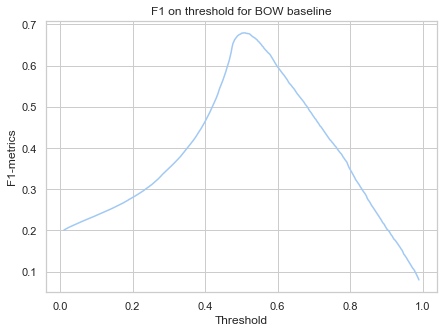

Wall time: 30.9 s


,name,f1_train,f1_test
0,BOW baseline,0.67935,0.65568


In [28]:
%%time
model = pipeline.Pipeline([
    ('trans', feature_extraction.text.CountVectorizer(
        #max_df=0.4,
        min_df=3,
        #max_features=None,
        stop_words=stop_words,
        strip_accents='unicode',
        lowercase=True)
    ),
    ('est', linear_model.LogisticRegression(solver='sag', max_iter=300, class_weight={0:1, 1:3}))
])
res = get_scores(model, df, feature_col_name='text', name='BOW baseline');
result = result.append(res, ignore_index=True).drop_duplicates()
result

Ну, мы были близко.

Попробуем еще naive_bayes - пишут, что он хорошо подходит для классификации текстов.

vocab length 45345


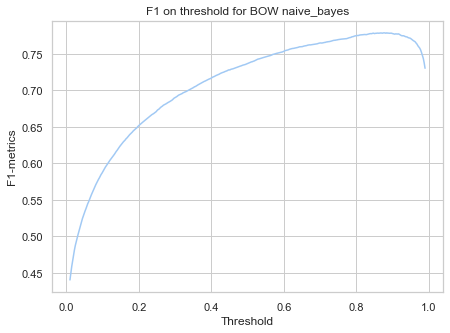

Wall time: 14.5 s


,name,f1_train,f1_test
0,BOW baseline,0.679350,0.655680
1,BOW naive_bayes,0.778877,0.737665


In [29]:
%%time
model = pipeline.Pipeline([
    ('trans', feature_extraction.text.CountVectorizer(
        #max_df=0.4,
        min_df=3,
        #max_features=None,
        stop_words=stop_words,
        strip_accents='unicode',
        lowercase=True)
    ),
    ('est', naive_bayes.MultinomialNB(class_prior=[0.3, 0.1]))
])
res = get_scores(model, df, feature_col_name='text', name='BOW naive_bayes');
result = result.append(res, ignore_index=True).drop_duplicates()
result

Тоже работает, но как-то не очень хорошо.

### TF-IDF (Term frequency–inverse document frequency)

Для начала запустим просто на текстах без обработки. TF-IDF сам по себе снижает важность стоп-слов, поэтому не будем их включать явно.

vocab length 19902


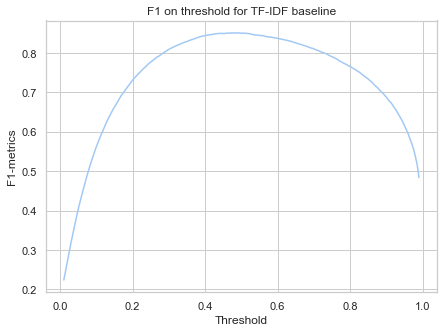

Wall time: 17.1 s


,name,f1_train,f1_test
0,BOW baseline,0.679350,0.655680
1,BOW naive_bayes,0.778877,0.737665
2,TF-IDF baseline,0.850960,0.791582


In [30]:
%%time
model = pipeline.Pipeline([
    ('trans', feature_extraction.text.TfidfVectorizer(
        sublinear_tf=True,
        max_df=0.6,
        min_df=10,
        # max_features=1000,
        # stop_words=stop_words,
        # ngram_range=(1,2),
        norm='l2',
        smooth_idf=True,
        strip_accents='unicode',
        lowercase=True)
    ),
    #('est', linear_model.LogisticRegression(solver='sag', class_weight='balanced'))
    ('est', linear_model.LogisticRegression(solver='sag', class_weight={0:1, 1:3}))
])
res = get_scores(model, df, feature_col_name='text', name='TF-IDF baseline')
result = result.append(res, ignore_index=True).drop_duplicates()
result

vocab length 19902


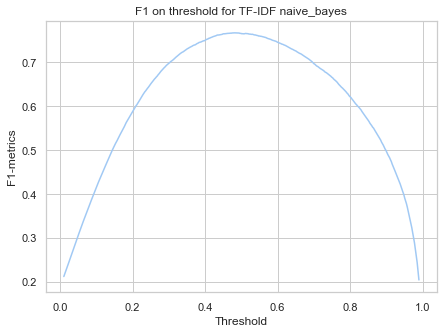

Wall time: 15.3 s


,name,f1_train,f1_test
0,BOW baseline,0.679350,0.655680
1,BOW naive_bayes,0.778877,0.737665
2,TF-IDF baseline,0.850960,0.791582
3,TF-IDF naive_bayes,0.767130,0.735087


In [31]:
%%time
model = pipeline.Pipeline([
    ('trans', feature_extraction.text.TfidfVectorizer(
        sublinear_tf=True,
        max_df=0.6,
        min_df=10,
        # max_features=1000,
        # stop_words=stop_words,
        # ngram_range=(1,2),
        norm='l2',
        smooth_idf=True,
        strip_accents='unicode',
        lowercase=True)
    ),
    ('est', naive_bayes.MultinomialNB(class_prior=[0.3, 0.1]))
])
res = get_scores(model, df, feature_col_name='text', name='TF-IDF naive_bayes')
result = result.append(res, ignore_index=True).drop_duplicates()
result

### Лемматизация

Попробуем немного почистить данные и сделать лемматизацию.

Будем использовать SpaCy как один самых мощных инструментов.

Загрузим пайплайн и посмотрим, из каких частей он состоит.

In [32]:
nlp = spacy.load('en_core_web_md')
nlp.pipe_names

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

Нам не нужны парсер и Named Entity Recognition (NER). Остальные элементы необходимы для лемматизации.

In [33]:
nlp.disable_pipes('parser', 'ner');

Посмотрим, как работает лемматизатор.

In [34]:
doc = nlp(df['text'][6])

for token in doc:
    print(token.text, "-->", token.lemma_, 'vector shape', token.vector.shape)

leave --> leave vector shape (300,)
your --> your vector shape (300,)
emotions --> emotion vector shape (300,)
out --> out vector shape (300,)
of --> of vector shape (300,)
it --> it vector shape (300,)
. --> . vector shape (300,)
that --> that vector shape (300,)
is --> be vector shape (300,)
the --> the vector shape (300,)
exact --> exact vector shape (300,)
issue --> issue vector shape (300,)
i --> I vector shape (300,)
am --> be vector shape (300,)
having --> have vector shape (300,)
with --> with vector shape (300,)
the --> the vector shape (300,)
majority --> majority vector shape (300,)
of --> of vector shape (300,)
the --> the vector shape (300,)
information --> information vector shape (300,)
contained --> contain vector shape (300,)
within --> within vector shape (300,)
this --> this vector shape (300,)
article --> article vector shape (300,)
- --> - vector shape (300,)
emotional --> emotional vector shape (300,)
and --> and vector shape (300,)
speculative --> speculative vec

У каждого слова уже есть семантический вектор.

Лемматизатор не может обработать опечатки и, например, отсутствие пробелов между словами.

А теперь самое долгое - надо лемматизировать весь датасет.

In [35]:
def spacy_lemmatizer(x, nlp):
    mytokens = [word.lemma_.lower().strip() for word in nlp(x)]
    return ' '.join(mytokens)

Для ускорения после первого же расчета сохраняем текст в отдельный файл, а потом просто загружаем его.

In [36]:
%%time
lemma_file_name = 'lemmatized_df.csv'
if os.path.exists(lemma_file_name):
    lemmatized_df = pd.read_csv(lemma_file_name)
    if len(lemmatized_df) == len(df):
        print('Good lemmatized docs are already in file')
        df['lemmas'] = lemmatized_df['text']
    else:
        print('File alreasy exists, but wrong length')
        df['lemmas'] = df['text'].apply(lambda x: spacy_lemmatizer(x, nlp)).to_frame()
else:
    lemmatized_df = df['text'].apply(lambda x: spacy_lemmatizer(x, nlp)).to_frame()
    lemmatized_df.to_csv(lemma_file_name)
    df['lemmas'] = lemmatized_df['text']
    print('Lemmatized docs were saved to file')

Good lemmatized docs are already in file
Wall time: 374 ms


### TF-IDF (опять)

Все то же, что и раньше, но на лемматизированном датасете.

vocab length 15946


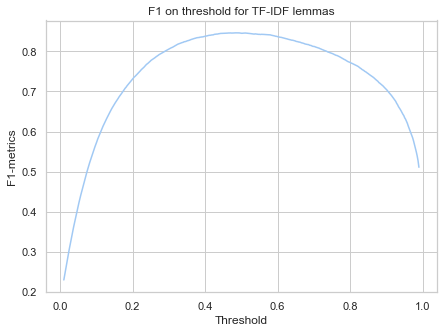

Wall time: 17.5 s


,name,f1_train,f1_test
0,BOW baseline,0.679350,0.655680
1,BOW naive_bayes,0.778877,0.737665
2,TF-IDF baseline,0.850960,0.791582
3,TF-IDF naive_bayes,0.767130,0.735087
4,TF-IDF lemmas,0.846397,0.796573


In [37]:
%%time
model_log = pipeline.Pipeline([
    ('trans', feature_extraction.text.TfidfVectorizer(
        sublinear_tf=True,
        max_df=0.6,
        min_df=10,
        # max_features=1000,
        # stop_words=stop_words,
        # ngram_range=(1,2),
        norm='l2',
        smooth_idf=True,
        strip_accents='unicode',
        lowercase=True)
    ),
    #('est', linear_model.LogisticRegression(solver='sag', class_weight='balanced'))
    ('est', linear_model.LogisticRegression(solver='sag', class_weight={0:1, 1:3}))
])
res = get_scores(model_log, df, feature_col_name='lemmas', name='TF-IDF lemmas')
result = result.append(res, ignore_index=True).drop_duplicates()
result

vocab length 15946


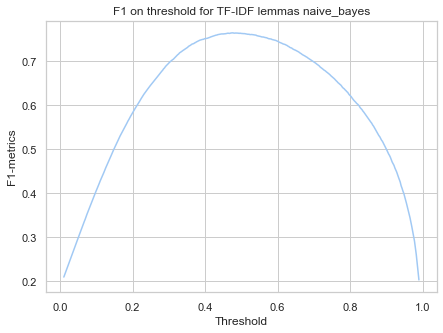

Wall time: 15.8 s


,name,f1_train,f1_test
0,BOW baseline,0.679350,0.655680
1,BOW naive_bayes,0.778877,0.737665
2,TF-IDF baseline,0.850960,0.791582
3,TF-IDF naive_bayes,0.767130,0.735087
4,TF-IDF lemmas,0.846397,0.796573
5,TF-IDF lemmas naive_bayes,0.765086,0.736705


In [38]:
%%time
model = pipeline.Pipeline([
    ('trans', feature_extraction.text.TfidfVectorizer(
        sublinear_tf=True,
        max_df=0.6,
        min_df=10,
        # max_features=1000,
        # stop_words=stop_words,
        # ngram_range=(1,2),
        norm='l2',
        smooth_idf=True,
        strip_accents='unicode',
        lowercase=True)
    ),
    ('est', naive_bayes.MultinomialNB(class_prior=[0.3, 0.1]))
])
res = get_scores(model, df, feature_col_name='lemmas', name='TF-IDF lemmas naive_bayes')
result = result.append(res, ignore_index=True).drop_duplicates()
result

### Vord2vec

Ради интереса попробуем еще классификацию на эмбеддингах по словам. Можно было бы использовать вектора слов из SpaCy, но попробуем библиотеку gensim.

Сначала посмотрим, как оно вообще выглядит.

In [39]:
w2v = gensim.downloader.load('word2vec-google-news-300')
r = w2v['test']
r

array([-1.42578125e-01, -3.68652344e-02,  1.35742188e-01, -6.20117188e-02,
        7.95898438e-02,  1.90429688e-02, -8.15429688e-02, -1.27929688e-01,
       -2.95410156e-02,  2.36328125e-01, -1.21582031e-01, -2.14843750e-01,
        1.29882812e-01, -2.70996094e-02, -5.20019531e-02,  2.15820312e-01,
       -1.81640625e-01,  5.10253906e-02, -1.60156250e-01, -1.76757812e-01,
        1.83105469e-02, -4.12597656e-02, -2.32421875e-01, -1.03149414e-02,
        1.45507812e-01,  5.24902344e-02, -3.96484375e-01, -1.92871094e-02,
        2.51770020e-03, -1.26953125e-02, -4.39453125e-02,  3.07617188e-02,
        9.57031250e-02, -1.75781250e-01,  1.04370117e-02,  1.89453125e-01,
       -2.36328125e-01,  4.37011719e-02,  2.81250000e-01, -2.07519531e-02,
       -1.81640625e-01, -2.17773438e-01,  2.33398438e-01,  5.29785156e-02,
       -1.13769531e-01,  9.39941406e-03, -1.49414062e-01,  1.99218750e-01,
       -1.75781250e-01,  3.16406250e-01,  8.10546875e-02, -6.12792969e-02,
       -1.52343750e-01, -

Каждое слово - вектор размерности 300.

Определим функцию векторизации предложения как среднего всех входящих в него векторов.

In [40]:
def get_text_vector(x):
    embeddings = []
    for word in x.split():
        if word not in stop_words:
            try:
                vec = w2v[word]
                embeddings.append(vec)
            except:
                pass
    if len(embeddings) > 0:
        return np.array(embeddings).mean(axis=0)
    else:
        return np.zeros(len(r))

Применим функцию ко всему датасету, на выходе получим матрицу.

In [41]:
%%time
g = df['text'].apply(get_text_vector)
emb_matrix = np.array(g.tolist())
emb_matrix

Wall time: 8.14 s


array([[ 0.02516533,  0.07161219, -0.03490134, ..., -0.05343089,
         0.00666226, -0.01511338],
       [-0.01525879,  0.07519531,  0.2265625 , ..., -0.20605469,
        -0.02880859,  0.07470703],
       [ 0.00667672, -0.01000645,  0.09285902, ..., -0.01546578,
        -0.0447653 ,  0.00628927],
       ...,
       [ 0.02839661,  0.07519531,  0.00087891, ..., -0.13664551,
         0.07528839, -0.09951172],
       [ 0.0651652 ,  0.00570679,  0.00060527, ..., -0.15246074,
        -0.07975515,  0.00871785],
       [ 0.01636598,  0.04076062, -0.01235592, ..., -0.03548709,
         0.00477924, -0.0370377 ]])

Линейная регрессия на эмбеддингах дала очень плохой результат.

Поэтому попробуем катубст.

Сначала создаем датасеты (объекты pool). В обучающем задаем веса классов.

In [42]:
train_pool = Pool(
    emb_matrix[small_train_idx],
    df['toxic'].values[small_train_idx],
    weight=df['toxic'].values[small_train_idx] * 2 + 1
)

val_pool = Pool(
    emb_matrix[small_val_idx],
    df['toxic'].values[small_val_idx]
)

test_pool = Pool(
    emb_matrix[test_idx],
    df['toxic'].values[test_idx]
)

Надо подобрать гиперпараметры. Поэтому используем оптуну.

In [43]:
def objective(trial):

    global train_pool, val_pool
    global df

    params = {
        'n_estimators': trial.suggest_categorical('n_estimators', [3000]),
        'early_stopping_rounds': trial.suggest_categorical('early_stopping_rounds', [200]),
        'max_depth': trial.suggest_int("max_depth", 2, 8),
        'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 1, 10),
        'bagging_temperature': trial.suggest_float("bagging_temperature", 0.1, 5),
        'min_data_in_leaf': trial.suggest_int("min_data_in_leaf", 1, 20),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise']),
        'random_state': trial.suggest_categorical('random_state', [random_state]),
        "eval_metric": trial.suggest_categorical('eval_metric', ["AUC"]),
        "loss_function": trial.suggest_categorical('loss_function', ['Logloss']),
        #'silent': trial.suggest_categorical('silent', [True]),
        'task_type': trial.suggest_categorical('task_type', ['GPU']),
        'use_best_model': trial.suggest_categorical('use_best_model', [True]),
        # 'auto_class_weights': trial.suggest_categorical('auto_class_weights', ['SqrtBalanced']),
        }
    cat_class = cat.CatBoostClassifier(**params)
    cat_class.fit(X=train_pool, metric_period=49, eval_set=val_pool)
    s = cat_class.eval_metrics(val_pool, 'AUC')#['F1', 'Precision', 'Recall', 'AUC'])

    return s['AUC'][-1]

In [ ]:
%%time
optuna.logging.set_verbosity(optuna.logging.WARNING)

study = optuna.create_study(direction="maximize")

study.optimize(objective,
               n_trials=None,
               timeout=60*60,
               n_jobs=1
               )
trial = study.best_trial
parameters = trial.params
num_runs = len(study.trials)
best_metr = trial.value

In [45]:
print("Количество запусков: {}".format(num_runs))
print("Лучший результат: метрика: {}".format(best_metr))
print('Оптимальные параметры:', parameters)

Количество запусков: 87
Лучший результат: метрика: 0.9358124728258387
Оптимальные параметры: {'n_estimators': 3000, 'early_stopping_rounds': 200, 'max_depth': 5, 'l2_leaf_reg': 5.317671255918376, 'bagging_temperature': 2.3092246229863274, 'min_data_in_leaf': 8, 'grow_policy': 'Depthwise', 'random_state': 2077, 'eval_metric': 'AUC', 'loss_function': 'Logloss', 'task_type': 'GPU', 'use_best_model': True}


А теперь повторяем то же, что и раньше: подбираем порог принятия решения на валидационной выборке.

В отдельной ячейке сохраним параметры, полученные часовым подбором.

In [ ]:
# parameters = {'n_estimators': 3000, 'early_stopping_rounds': 200, 'max_depth': 5, 'l2_leaf_reg': 5.317671255918376, 'bagging_temperature': 2.3092246229863274, 'min_data_in_leaf': 8, 'grow_policy': 'Depthwise', 'random_state': 2077, 'eval_metric': 'AUC', 'loss_function': 'Logloss', 'task_type': 'GPU', 'use_best_model': True}

In [ ]:
cat_class = cat.CatBoostClassifier(**parameters)
cat_class.fit(X=train_pool, metric_period=49, eval_set=val_pool);

best F1 = 0.6803840877914951, best threshold = 0.4793787575150301


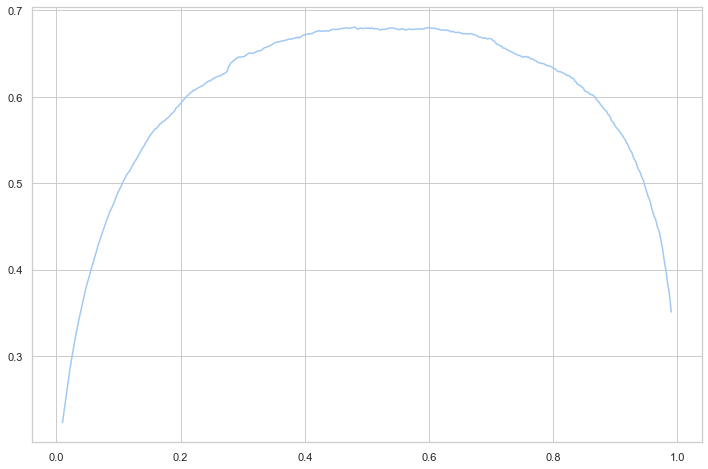

In [48]:
tmp = cat_class.predict_proba(val_pool)
best_i = 0
best_f = 0
x = []
y = []
for i in np.linspace(0.01, 0.99, 500):
    f = metrics.f1_score(df['toxic'].loc[small_val_idx].values, (tmp[:,1] > i))
    x.append(i)
    y.append(f)
    if f > best_f:
        best_f = f
        best_i = i

sns.lineplot(x=x, y=y)
print(f'best F1 = {best_f}, best threshold = {best_i}')

In [49]:
p = cat_class.predict_proba(test_pool)
test_metr = metrics.f1_score(df['toxic'].loc[test_idx].values, p[:,1] > best_i)
res = dict(
    name="vord2vec catboost",
    f1_train=best_f,
    f1_test=test_metr
)
result = result.append(res, ignore_index=True).drop_duplicates()
result

,name,f1_train,f1_test
0,BOW baseline,0.679350,0.655680
1,BOW naive_bayes,0.778877,0.737665
2,TF-IDF baseline,0.850960,0.791582
3,TF-IDF naive_bayes,0.767130,0.735087
4,TF-IDF lemmas,0.846397,0.796573
5,TF-IDF lemmas naive_bayes,0.765086,0.736705
6,vord2vec catboost,0.680384,0.686553


Видим, что результат не очень. Вероятно, обычное усреднение векторов слов - плохая идея, потому что при этом не передается ни смысл всего текста (как в БЕРТе), ни мощность отдельных "вредных" слов как в TF-IDF.

## BERT

Чтобы было удобно работать с данными, надо сделать:
- датасет, который будет построчно возвращать нужные нам для обучения значения
- даталоадер, который будет брать батчи из датасета

In [50]:
class ReviewDatasetTokenization(torch.utils.data.Dataset):

    def __init__(self, reviews, targets, tokenizer, max_len=300):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, item):
        coded = tokenizer.encode_plus(
            self.reviews[item],
            max_length=self.max_len,
            add_special_tokens=True, # Add '[CLS]' and '[SEP]'
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='np',  # Return PyTorch tensors
            truncation=True,
        )
        return coded['input_ids'][0], coded['attention_mask'][0], self.reviews[item], self.targets[item]

In [51]:
def plot_train_curves(history, name=''):
    train_loss, val_loss, train_metr, val_metr, lr = history['train_loss'], history['val_loss'], history['train_metr'], history['val_metr'], history['lr'],
    fig = plt.figure(figsize=(6,8))
    fig.patch.set_facecolor('xkcd:white')
    plt.subplot(3,1,1)
    points = np.array(train_loss + val_loss, dtype=float)
    points = points[~np.isnan(points)]
    points = points[np.isfinite(points)]
    p = 0.08
    q1, q2 = np.nanquantile(points, p), np.nanquantile(points, 1-p)
    iqr = q2 - q1
    lim1 = max(np.nanmin(points) - iqr * 0.06, q1 - iqr * 1.2)
    lim2 = min(np.nanmax(points) + iqr * 0.06, q2 + iqr * 1.2)
    plt.plot(train_loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend()
    plt.ylim(lim1, lim2)
    plt.xlabel("epochs")
    plt.ylabel("loss")

    plt.subplot(3,1,2)
    plt.plot(train_metr, label="train_metr")
    plt.plot(val_metr, label="val_metr")
    my = np.array(val_metr).max()
    mx = np.argmax(np.array(val_metr))
    plt.scatter(x=[mx], y=[my], c='red', s=80)
    plt.legend()
    plt.xlabel("epochs")
    plt.ylabel("metric")

    plt.subplot(3,1,3)
    plt.plot(lr, label="LR")
    plt.xlabel("epochs")
    plt.ylabel("LR")
    plt.yscale('log')

    if len(name) > 0:
        plt.suptitle(name)
    fig.patch.set_facecolor('xkcd:white')
    fig.tight_layout()
    plt.savefig(name+'.png')
    plt.show()

In [52]:
def train(model, optimizer, loss_fn, epochs, data_tr, data_val, metric,
          scheduler=None, set_best_params=True, name=''):

    best_metr = 0
    best_epoch = 0
    best_model_wts = copy.deepcopy(model.state_dict())

    model.eval()
    Y_preds = []
    Y_labels = []
    with torch.no_grad():
        for i, (batch) in enumerate(data_val):
            id_batch = batch[0].to(DEVICE)
            mask_batch = batch[1].to(DEVICE)
            Y_batch = batch[-1]
            Y_labels.append(Y_batch.cpu().detach().numpy().flatten()) # save GT
            Y_rough = model(id_batch, mask_batch)
            Y_preds.append(torch.sigmoid(Y_rough).cpu().detach().numpy())

    Y_preds = np.hstack(Y_preds)
    Y_labels = np.hstack(Y_labels)
    best_metr = metric(Y_labels, Y_preds).mean()

    history = dict(
        train_loss = [],
        val_loss = [],
        train_metr = [],
        val_metr = [],
        lr = []
    )

    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}, best = {best_epoch}')

        history['lr'].append(optimizer.param_groups[0]["lr"])

        avg_loss = 0
        model.train()  # train mode
        Y_preds = [] # probabilities [0..1]
        Y_labels = [] # GT 0 or 1
        losses = []
        for i, (batch) in enumerate(data_tr):
            id_batch = batch[0].to(DEVICE)
            mask_batch = batch[1].to(DEVICE)
            Y_batch = batch[-1]
            Y_labels.append(Y_batch.cpu().detach().numpy()) # save GT
            Y_batch = Y_batch.to(DEVICE)
            optimizer.zero_grad()

            # forward
            Y_rough = model(id_batch, mask_batch) # get rough output (-inf..inf)
            Y_preds.append(torch.sigmoid(Y_rough).cpu().detach().numpy()) # append prob [0..1]
            loss = loss_fn(Y_rough, Y_batch.float()) # loss based on rough
            loss.backward()
            losses.append(loss.cpu().detach().item())
            optimizer.step()

        Y_preds = np.hstack(Y_preds)
        Y_labels = np.hstack(Y_labels)
        epoch_loss = np.array(losses).mean()
        history['train_metr'].append(metric(Y_labels, Y_preds).mean())
        history['train_loss'].append(epoch_loss)

        model.eval()  # testing mode
        # X_texts = []
        Y_preds = []
        Y_labels = []
        losses = []
        with torch.no_grad():
            for i, (batch) in enumerate(data_val):
                id_batch = batch[0].to(DEVICE)
                mask_batch = batch[1].to(DEVICE)
                Y_batch = batch[-1]
                Y_labels.append(Y_batch.cpu().detach().numpy().flatten()) # save GT
                Y_batch = Y_batch.to(DEVICE)

                Y_rough = model(id_batch, mask_batch)
                Y_preds.append(torch.sigmoid(Y_rough).cpu().detach().numpy())

                loss = loss_fn(Y_rough, Y_batch.float())
                losses.append(loss.cpu().detach().item())

        Y_preds = np.hstack(Y_preds)
        Y_labels = np.hstack(Y_labels)
        epoch_loss = np.array(losses).mean()
        history['val_metr'].append(metric(Y_labels, Y_preds).mean())
        history['val_loss'].append(epoch_loss)

        # if best_metr == None: best_metr = history['val_metr'][-1]

        if scheduler != None: scheduler.step(history['val_loss'][-1])

        # Visualize tools
        if epoch > 0:
            clear_output(wait=True)
            plot_train_curves(history, name)

        if history['val_metr'][-1] > best_metr:
            print('new best val metric!')
            best_epoch = epoch + 1
            best_metr = history['val_metr'][-1]
            best_model_wts = copy.deepcopy(model.state_dict())

    if set_best_params:
        model.load_state_dict(best_model_wts)
        print(f'Weights loaded from best epoch {best_epoch}, metric = {best_metr:0.4f}')

    return(history)

In [53]:
def predict(model, dl, save_text=False):
    model.to(DEVICE)
    model.eval()  # testing mode
    X_texts = []
    Y_preds = []
    Y_labels = []

    with torch.no_grad():
        for i, (batch) in enumerate(dl):
            if save_text:
                X_texts += list(batch[2])
            id_batch = batch[0].to(DEVICE)
            mask_batch = batch[1].to(DEVICE)
            Y_batch = batch[-1]
            Y_labels.append(Y_batch.cpu().detach().numpy().flatten()) # save GT

            Y_rough = model(id_batch, mask_batch)
            Y_preds.append(torch.sigmoid(Y_rough).cpu().detach().numpy())

    Y_preds = np.hstack(Y_preds)
    Y_labels = np.hstack(Y_labels)
    if save_text:
        return Y_labels, Y_preds, X_texts
    else:
        return Y_labels, Y_preds

In [54]:
def create_dataloader(idx, df, tokenizer, batch_size=8, shuffle=False, max_len=300):
    ds = ReviewDatasetTokenization(reviews=df['text'].loc[idx].values,
                                  targets=df['toxic'].loc[idx].values,
                                   tokenizer=tokenizer, max_len=max_len)
    return torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=shuffle)

In [55]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [56]:
train_dl = create_dataloader(small_train_idx, df, tokenizer, shuffle=True, batch_size=16)
val_dl = create_dataloader(small_val_idx, df, tokenizer, batch_size=16)
test_dl = create_dataloader(test_idx, df, tokenizer, batch_size=16)

In [57]:
for i in train_dl:
    print(i[0].shape)
    print(i[1].shape)
    print(i[-1].shape)
    break

torch.Size([16, 300])
torch.Size([16, 300])
torch.Size([16])


In [58]:
class BertClassifier(nn.Module):

    def __init__(self, PRE_TRAINED_MODEL_NAME):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        output = self.drop(bert_output.pooler_output)
        return self.out(output).flatten()

In [59]:
clear_GPU()
bert_model = BertClassifier(PRE_TRAINED_MODEL_NAME='bert-base-uncased')
bert_model.to(DEVICE);

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Снача параметры файн-тюнинга были взяты из [оригинальной статьи](https://arxiv.org/pdf/1810.04805.pdf). Потом вручную подобраны так, чтобы результат достигался быстрее всего.

К сожалению, большой размер батча не влезает в видеокарту.

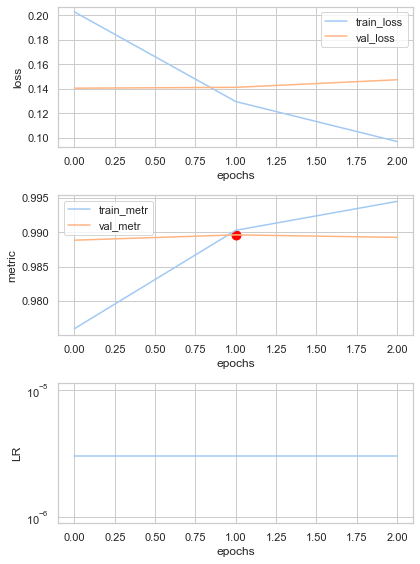

Weights loaded from best epoch 2, metric = 0.9896
Wall time: 2h 21min 50s


In [60]:
%%time
loss = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([3.]).to(DEVICE))
max_epochs = 3
base_lr = 3e-6
optim = torch.optim.AdamW(params=bert_model.parameters(), lr=base_lr)

hist = train(bert_model, optim, loss, max_epochs, train_dl, val_dl, metric=metrics.roc_auc_score);

Но это еще не все. Мы оптимизировали метрику ROC AUC. А теперь надо подобрать порог принятия решения, чтобы оптимизировать метрику F1.

Для этого опять воспользуемся валидационным сетом.

In [61]:
%%time
v = predict(bert_model, val_dl, save_text=True)

Wall time: 3min 49s


best F1 = 0.8591688004727202, best threshold = 0.8544889779559119


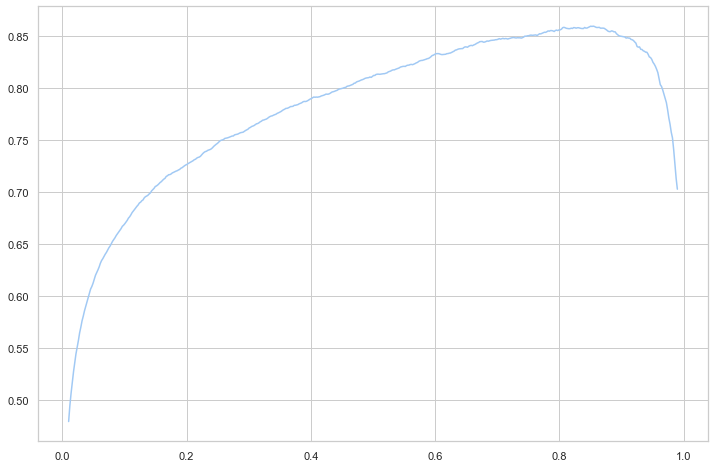

In [62]:
best_i = 0
best_f = 0
x = []
y = []
for i in np.linspace(0.01, 0.99, 500):
    f = metrics.f1_score(v[0], v[1] > i)
    x.append(i)
    y.append(f)
    if f > best_f:
        best_f = f
        best_i = i

sns.lineplot(x=x, y=y)

print(f'best F1 = {best_f}, best threshold = {best_i}')

In [63]:
r = predict(bert_model, test_dl, save_text=True)
f_test = metrics.f1_score(r[0], r[1]>best_i)
res = dict(
    name="BERT fine-tuned",
    f1_train=best_f,
    f1_test=f_test
)
print(f'F1 on test set = {f_test}')

F1 on test set = 0.8423070778079566


Посмотрим еще на ошибки нашей модели, причем на самые сильные, где вероятность, предсказанная моделью, максимально отличается от реального класса.

In [64]:
d = pd.DataFrame(r).T.rename(columns={0:'toxic', 1:'pred',2:'text'})
d['error'] = (d['pred']-d['toxic']).abs()
d.sort_values('error', ascending=False).head(10)

,toxic,pred,text,error
1456,0,0.999082,you are retarded\nlearn to type like you're no...,0.999082
3828,1,0.001019,justin likes it in the behind...,0.998981
28006,1,0.001027,give a on them. i inserted,0.998973
2317,1,0.001371,redirect talk:bolivian chinchilla rat,0.998629
23938,0,0.998585,as for the 'blethering scot' shite you can gtf...,0.998585
30733,0,0.997961,"eat my shorts \neat my shorts, arsefacey.",0.997961
24479,1,0.002276,please stop. if you continue to ignore our pol...,0.997724
2096,0,0.996986,"\nwell, why didn't you point this out in the f...",0.996986
27051,0,0.996298,nacreous cloud article \ni'll edit whatever i ...,0.996298
808,1,0.003797,"e-dog, on another page, you wrote: \nthanks f...",0.996203


В целом тут как-то неоднозначно - есть записи, которые кажутся неверно помеченными изначально. Ну или как минимум неоднозначными.

In [65]:
result = result.append(res, ignore_index=True).drop_duplicates()
result

,name,f1_train,f1_test
0,BOW baseline,0.679350,0.655680
1,BOW naive_bayes,0.778877,0.737665
2,TF-IDF baseline,0.850960,0.791582
3,TF-IDF naive_bayes,0.767130,0.735087
4,TF-IDF lemmas,0.846397,0.796573
5,TF-IDF lemmas naive_bayes,0.765086,0.736705
6,vord2vec catboost,0.680384,0.686553
7,BERT fine-tuned,0.859169,0.842307


## Выводы

- проведена предварительная "мягкая" очистка текста от частей, не поддающихся анализу: ссылок, IP, специальных символов и т.д.
- обучена логистическая регрессия и наивный Байес на мешке слов и на признаках TF-IDF до и после лемматизации. Лучший результат - логистчиеская регрессия на TF-IDF после лемматизации
- обучена модель catboost на эмбеддингах предложений, полученных усреднением векторов слов из модуля Word2vec библиотеки gensim. Результат хуже, чем у логистической регрессии на мешке слов. Вероятно, простое усреднение векторов слов не позволяет модели понять смысл длинных текстов
- модель BERT (base uncased) дообучена на обучающей выборке. Дообученная модель на тестовой выборке имеет метрику значтельно выше, чем логистическая регрессия

Идеи для улучшения результата:
- более глубокая очистка текста. Требует просмотра записей и составления паттернов вручную. Сделано вручную частично, результат значительно улучшился. Потенциально может дать очень хороший прирост метрики и на простых, и на сложных моделях, но требует времени
- подбор гиперпараметров TF-IDF и логистической регрессии. Требует большого количества времени на перебор значений и кросс-валидацию. В работе сделано частично и вручную, дает незначительный прирост
- подбор параметров обучения BERT. Вероятно, снижение скорости обучения и увеличение количества эпох может положительно сказать на целевой метрике. Кажется, что при использовании параметров, предлагаемых авторами BERT в оригинальной статье, модель очень быстро переобучается
- использование FastText для эффективной обработки слов с опечатками